Main objectives of assignment:

● Predict the cumulative revenue of the flight PG0708 departing on the 15th of September
2017 for each date up to 30 days before departure

● Present the features that are the most relevant to the prediction

Let's start exploring the dataset by having a quick look at all the tables contained in it

In [415]:

import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns


# Path to the SQLite database file
db_path = 'travel.sqlite'

# Establish a connection to the database
conn = sqlite3.connect(db_path)

# Retrieve all table names in the database
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(query, conn)

# Loop through all tables and print their columns
for table in tables['name']:
    print(f"Table: {table}")
    table_info = pd.read_sql_query(f"PRAGMA table_info({table});", conn)
    print("Columns:", table_info['name'].tolist())
    print("-" * 40)

# Close the database connection
conn.close()


Table: aircrafts_data
Columns: ['aircraft_code', 'model', 'range']
----------------------------------------
Table: airports_data
Columns: ['airport_code', 'airport_name', 'city', 'coordinates', 'timezone']
----------------------------------------
Table: boarding_passes
Columns: ['ticket_no', 'flight_id', 'boarding_no', 'seat_no']
----------------------------------------
Table: bookings
Columns: ['book_ref', 'book_date', 'total_amount']
----------------------------------------
Table: flights
Columns: ['flight_id', 'flight_no', 'scheduled_departure', 'scheduled_arrival', 'departure_airport', 'arrival_airport', 'status', 'aircraft_code', 'actual_departure', 'actual_arrival']
----------------------------------------
Table: seats
Columns: ['aircraft_code', 'seat_no', 'fare_conditions']
----------------------------------------
Table: ticket_flights
Columns: ['ticket_no', 'flight_id', 'fare_conditions', 'amount']
----------------------------------------
Table: tickets
Columns: ['ticket_no', '

We note that not all tables are relevanto for our use case:

aircraft_data: not relevant

airports_data: not relevant

boarding_passes: not relevant

bookings: relevant

flights: relevant

seats: not relevant

ticket_flights: relevant

tickets: relevant

The relevancy is decided based on whether a table contains features associated with the objective of the assignment: ticket revenue and variables that can influence it e.g. aircraft type may hardly influence the choice of a route;  business/economy is  already indicrectly included in the ticket price

In [416]:

# Connect to the SQLite database
conn = sqlite3.connect('travel.sqlite')

# Load the tables from the SQLite database
bookings = pd.read_sql_query("SELECT * FROM bookings", conn)
flights = pd.read_sql_query("SELECT * FROM flights", conn)
ticket_flights = pd.read_sql_query("SELECT * FROM ticket_flights", conn)
tickets = pd.read_sql_query("SELECT * FROM tickets", conn)

# Close the connection
conn.close()

In [417]:
# Display the first few rows of each table
print("Bookings DataFrame:")
print(bookings.head())
print("\nFlights DataFrame:")
print(flights.head())
print("\nTicket Flights DataFrame:")
print(ticket_flights.head())
print("\nTickets DataFrame:")
print(tickets.head())

# Display the shape of each table
print("\nShape of Bookings:", bookings.shape)
print("Shape of Flights:", flights.shape)
print("Shape of Ticket Flights:", ticket_flights.shape)
print("Shape of Tickets:", tickets.shape)

# Describe the statistics of each table
print("\nStatistics for Bookings:")
print(bookings.describe(include='all'))
print("\nStatistics for Flights:")
print(flights.describe(include='all'))
print("\nStatistics for Ticket Flights:")
print(ticket_flights.describe(include='all'))
print("\nStatistics for Tickets:")
print(tickets.describe(include='all'))


Bookings DataFrame:
  book_ref               book_date  total_amount
0   00000F  2017-07-05 03:12:00+03        265700
1   000012  2017-07-14 09:02:00+03         37900
2   000068  2017-08-15 14:27:00+03         18100
3   000181  2017-08-10 13:28:00+03        131800
4   0002D8  2017-08-07 21:40:00+03         23600

Flights DataFrame:
   flight_id flight_no     scheduled_departure       scheduled_arrival  \
0       1185    PG0134  2017-09-10 09:50:00+03  2017-09-10 14:55:00+03   
1       3979    PG0052  2017-08-25 14:50:00+03  2017-08-25 17:35:00+03   
2       4739    PG0561  2017-09-05 12:30:00+03  2017-09-05 14:15:00+03   
3       5502    PG0529  2017-09-12 09:50:00+03  2017-09-12 11:20:00+03   
4       6938    PG0461  2017-09-04 12:25:00+03  2017-09-04 13:20:00+03   

  departure_airport arrival_airport     status aircraft_code actual_departure  \
0               DME             BTK  Scheduled           319               \N   
1               VKO             HMA  Scheduled           CR

Observations:
1. departure_airport, arrival_airport are constant which means geographic features might not be as influential since there's no variation in this dataset
2. status and fare_conditions fields are categorical and should be treated accordingly, possibly with one-hot encoding if used as features in a model
3. actual_departure and actual_arrival times include a significant number of '\N' values (interpreted as missing or not applicable). For modeling, these will need to be carefully handled, possibly by considering them as features that indicate whether a flight's actual times were recorded

After a more careful look we observe that all flights are on status 'arrived' (and so, have an actual_departure date that is not '\N') up to 17-08-15 which is also the cutoff point for our analysis

4. The amount in ticket_flights varies significantly, from 3,000 to 203,300, indicating diverse ticket pricing which will be crucial for revenue predictions.
5. book_ref, ticket_no, and passenger_id are unique identifiers across their respective datasets. These might be less useful directly as features for predictive modeling 
6. total_amount in bookings has a wide range, suggesting variability in booking costs that could be explored further for insights.



In [418]:
# Check for missing data in each DataFrame
print("\nMissing values in Bookings:")
print(bookings.isnull().sum())
print("\nMissing values in Flights:")
print(flights.isnull().sum())
print("\nMissing values in Ticket Flights:")
print(ticket_flights.isnull().sum())
print("\nMissing values in Tickets:")
print(tickets.isnull().sum())



Missing values in Bookings:
book_ref        0
book_date       0
total_amount    0
dtype: int64

Missing values in Flights:
flight_id              0
flight_no              0
scheduled_departure    0
scheduled_arrival      0
departure_airport      0
arrival_airport        0
status                 0
aircraft_code          0
actual_departure       0
actual_arrival         0
dtype: int64

Missing values in Ticket Flights:
ticket_no          0
flight_id          0
fare_conditions    0
amount             0
dtype: int64

Missing values in Tickets:
ticket_no       0
book_ref        0
passenger_id    0
dtype: int64


No missing values observed!

In [419]:
# Print the data types of each DataFrame
print("\nData Types in Bookings:")
print(bookings.dtypes)
print("\nData Types in Flights:")
print(flights.dtypes)
print("\nData Types in Ticket Flights:")
print(ticket_flights.dtypes)
print("\nData Types in Tickets:")
print(tickets.dtypes)



Data Types in Bookings:
book_ref        object
book_date       object
total_amount     int64
dtype: object

Data Types in Flights:
flight_id               int64
flight_no              object
scheduled_departure    object
scheduled_arrival      object
departure_airport      object
arrival_airport        object
status                 object
aircraft_code          object
actual_departure       object
actual_arrival         object
dtype: object

Data Types in Ticket Flights:
ticket_no          object
flight_id           int64
fare_conditions    object
amount              int64
dtype: object

Data Types in Tickets:
ticket_no       object
book_ref        object
passenger_id    object
dtype: object


Date variables need to be cinverted from objects to datetime before being used in a model!

Solutution Approach: calculate the aggregated revenue generated for each departure of the flight PG0708 before the 15/9 - 30d cut off point. This will provide historical values of the varable of interest which can be used to build a model.

Assumption 1: book_ref refers to a booking that can include one or more passengers  -it may include non-individual extras too (e.g. ticket change flexibility); ticket_no refers to the ticket of a single passenger and is tied to them -> one booking_ref may include multiple ticket_no

![Screenshot](images/1.png)

It is observed that there are bookings whose total_amount is much higher than the sum of the individual tickets included in them -> this indicates that other flights might be included in a booking, rendering the total_amount unsusable for our use case

Assumption 2: flight_no refers to a flight route with a specific time slot; flight_id refers to a unique instance of a flight_no tied to a specific date -> one flight_no includes multiple flight_id

In order to achieve my objective i will need to calculate the revenue per flight_id/date based on the total booking revenue;  I choose ticket revenue to avoid including revenue generated by other flights within the same booking.


Assumption 2 verified in DBeaver:

![Screenshot](images/2.png)

In [420]:
# Explore status and fare_conditions
print(flights['status'].value_counts())
print(ticket_flights['fare_conditions'].value_counts())
print(flights['aircraft_code'].value_counts())


status
Arrived      16707
Scheduled    15383
On Time        518
Cancelled      414
Departed        58
Delayed         41
Name: count, dtype: int64
fare_conditions
Economy     920793
Business    107642
Comfort      17291
Name: count, dtype: int64
aircraft_code
CN1    9273
CR2    9048
SU9    8504
321    1952
733    1274
319    1239
763    1221
773     610
Name: count, dtype: int64


Features to Drop

ticket_no: Primarily an identifier and doesn't contribute to aggregate revenue prediction.

flight_no: Since we are analyzing cumulative revenue for a specific flight or flights identified by flight_id, this might be redundant.

departure_airport, arrival_airport: These are constant for the specific flight route being analyzed (based on previous filter for PG0708)

aircraft_code: same for all flights

book_ref, passenger_id: More relevant for individual ticket analysis, less for aggregated revenue.

book_date: While the booking date is crucial for time-based features, but since i am aggregating by days until departure, I might not need the exact booking date after computing other time-based features

total_amount: Represents the booking total, but since I'm focusing on ticket amounts (amount) that contribute directly to flight revenue, this can be omitted 

In [421]:
# Drop the columns that are considered less relevant for the analysis
columns_to_drop = ['ticket_no', 'departure_airport', 'arrival_airport', 
                   'aircraft_code', 'book_ref', 'passenger_id', 'book_date', 'total_amount','fare_conditions', 'actual_departure', 'actual_arrival', 'status', 'scheduled_arrival' ]
full_data = pd.merge(ticket_flights, flights, on='flight_id')
full_data = pd.merge(full_data, tickets, on='ticket_no')
full_data = pd.merge(full_data, bookings, on='book_ref')

# Dropping the specified columns
full_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Replace '\\N' with np.nan to ensure they are treated as missing values
full_data.replace('\\N', np.nan, inplace=True)

In [422]:
# Convert date/time columns
full_data['scheduled_departure'] = pd.to_datetime(full_data['scheduled_departure'], errors='coerce', utc=True)


To predict cumulative revenue, aggregate the amount from ticket_flights by flight_id and the days until the flight.

In [423]:
# Filter for flight PG0708 specifically
target_flight_no = 'PG0708'
full_data = full_data[full_data['flight_no'] == target_flight_no]

# Group by all remaining columns except 'amount', summing the 'amount'
grouping_columns = [col for col in full_data.columns if col != 'amount']
grouped_data = full_data.groupby(grouping_columns, dropna=False).agg(total_revenue=pd.NamedAgg(column='amount', aggfunc='sum')).reset_index()

# Check the total revenue before and after grouping
print("\nSum of 'amount' in original data:", full_data['amount'].sum())
print("Sum of 'total_revenue' in grouped data:", grouped_data['total_revenue'].sum())

# Print a sample of the grouped data to inspect
print("\nGrouped Data Sample:")
print(grouped_data.head())


Sum of 'amount' in original data: 12778000
Sum of 'total_revenue' in grouped data: 12778000

Grouped Data Sample:
   flight_id flight_no       scheduled_departure  total_revenue
0      32040    PG0708 2017-09-04 14:15:00+00:00         177900
1      32041    PG0708 2017-08-16 14:15:00+00:00         255600
2      32042    PG0708 2017-07-16 14:15:00+00:00         166700
3      32043    PG0708 2017-08-21 14:15:00+00:00         208600
4      32044    PG0708 2017-08-18 14:15:00+00:00         287000


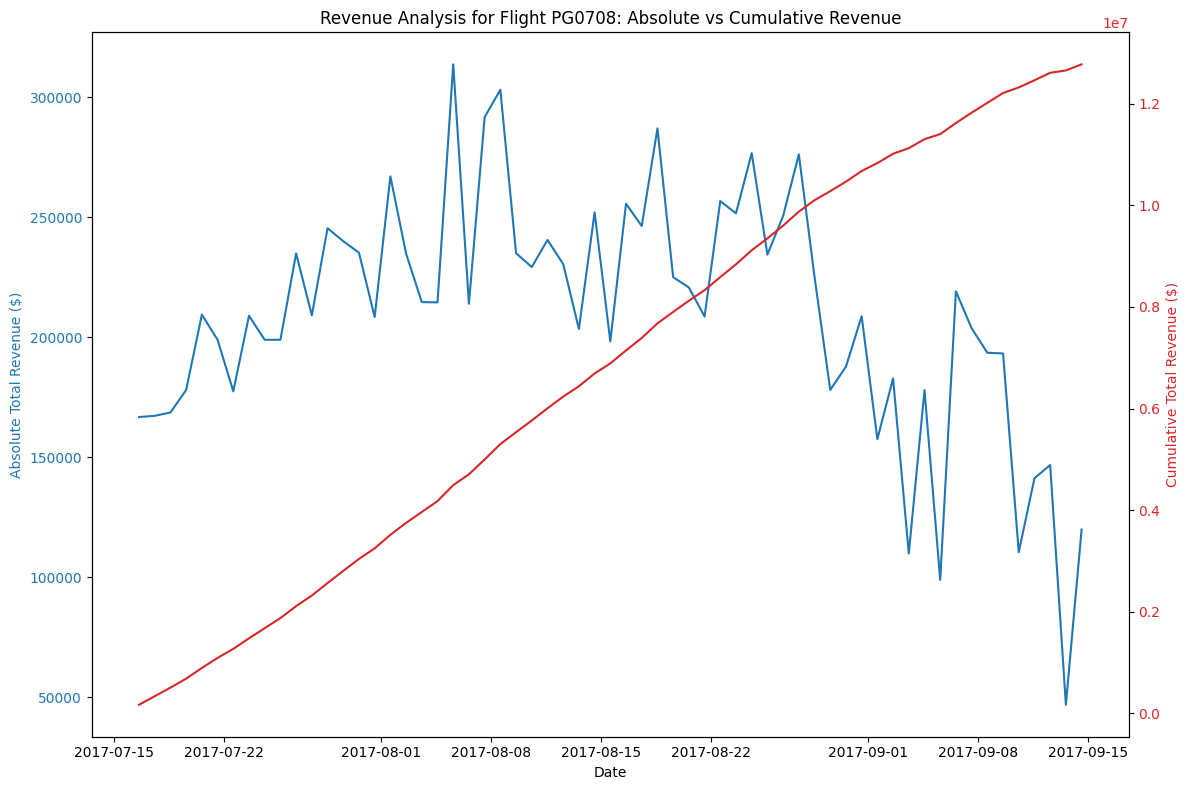

In [424]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Ensure 'scheduled_departure' is a datetime object
grouped_data['scheduled_departure'] = pd.to_datetime(grouped_data['scheduled_departure'])

# Sort the data by 'scheduled_departure' to ensure proper cumulative calculation
grouped_data.sort_values('scheduled_departure', inplace=True)

# Aggregate revenue per day if there are multiple entries per day
daily_revenue = grouped_data.groupby('scheduled_departure')['total_revenue'].sum().reset_index()

# Calculate cumulative revenue
daily_revenue['cumulative_revenue'] = daily_revenue['total_revenue'].cumsum()

# Plotting with dual y-axes
fig, ax1 = plt.subplots(figsize=(12, 8))

# Absolute total revenue
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Absolute Total Revenue ($)', color=color)
sns.lineplot(data=daily_revenue, x='scheduled_departure', y='total_revenue', color=color, ax=ax1)
ax1.tick_params(axis='y', labelcolor=color)

# Cumulative total revenue
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Cumulative Total Revenue ($)', color=color)
sns.lineplot(data=daily_revenue, x='scheduled_departure', y='cumulative_revenue', color=color, ax=ax2)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Revenue Analysis for Flight PG0708: Absolute vs Cumulative Revenue')
fig.tight_layout()
plt.show()


In the plot above we should consider only the left half since we want to predict the values after September 14th.
To avoid accumulating errors, we will first predict the total_revenue and then sum it up to arrive to the cumulative one.

The total_revenue metric in the plot exhibits:
- A strong upward trend across all the timeframe
- A repetitive seasonal trend in smaller regular intervals

Thus a SARIMA model  would be appropriate.


In [426]:
# Dropping the specified columns
grouped_data.drop(columns='flight_no' , inplace=True, errors='ignore')
grouped_data.drop(columns='flight_id' , inplace=True, errors='ignore')

In [427]:
# Assuming 'grouped_data' is your DataFrame
grouped_data['day_of_week'] = grouped_data['scheduled_departure'].dt.dayofweek
grouped_data['scheduled_departure'] = pd.to_datetime(grouped_data['scheduled_departure']).dt.date


# Now your 'scheduled_departure' column will only contain the date part
print(grouped_data.head())


   scheduled_departure  total_revenue  day_of_week
2           2017-07-16         166700            6
9           2017-07-17         167200            0
12          2017-07-18         168600            1
16          2017-07-19         178000            2
60          2017-07-20         209400            3


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.28280D+00    |proj g|=  2.32897D-01

At iterate    5    f=  5.25385D+00    |proj g|=  5.06912D-02

At iterate   10    f=  5.24562D+00    |proj g|=  2.81423D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     13     17      1     0     0   2.267D-06   5.246D+00
  F =   5.2456015072515179     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/a31614/Downloads/Sqills/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/a31614/Downloads/Sqills/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


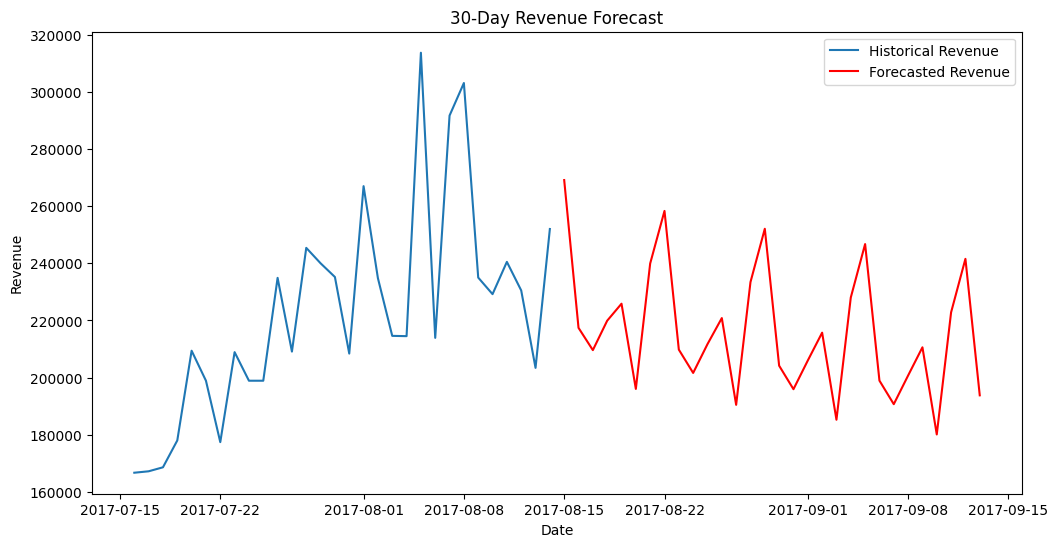

In [428]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Convert 'scheduled_departure' to datetime and set as index if not already
grouped_data['scheduled_departure'] = pd.to_datetime(grouped_data['scheduled_departure'])
grouped_data.set_index('scheduled_departure', inplace=True)
grouped_data.sort_index(inplace=True)

# Ensure all data types are appropriate
# Convert 'day_of_week' to categorical and create dummy variables, drop the first to avoid multicollinearity
grouped_data['day_of_week'] = grouped_data['day_of_week'].astype('category')
dummies = pd.get_dummies(grouped_data['day_of_week'], prefix='dow', drop_first=True)
grouped_data = pd.concat([grouped_data, dummies], axis=1)

# Remove the original 'day_of_week' column if it's still in the DataFrame
grouped_data.drop(columns=['day_of_week'], inplace=True)

# Convert any boolean columns to int (assuming all should be numeric for SARIMAX)
boolean_columns = grouped_data.select_dtypes(include=[bool]).columns
grouped_data[boolean_columns] = grouped_data[boolean_columns].astype(int)

# Training data: All data before August 15th, 2017
train_data = grouped_data[:'2017-08-14']

# Fit the SARIMAX model
model = SARIMAX(train_data['total_revenue'],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 7),
                exog=train_data.iloc[:, 1:],  # Assuming 'total_revenue' is the first column
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

# Forecast the next 30 days, provide the day of the week features for these days
last_day = train_data.index.max()
future_dates = pd.date_range(start=last_day + pd.Timedelta(days=1), periods=30, freq='D')
future_dummies = pd.get_dummies(future_dates.dayofweek, prefix='dow').iloc[:, 1:]  # Match training dummies format
future_dummies = future_dummies.reindex(columns=dummies.columns, fill_value=0)

forecast = results.get_forecast(steps=30, exog=future_dummies)
predicted_mean = forecast.predicted_mean

# Plotting the forecast
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['total_revenue'], label='Historical Revenue')
plt.plot(future_dates, predicted_mean, color='r', label='Forecasted Revenue')
plt.title('30-Day Revenue Forecast')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.show()
